# To-Dos

In [65]:
## Outlier Removal
## Time zone is Data Pull
## Cumulative Logic

# Import Packages

In [1]:
check.packages = function(pkg) {
    new.pkg = pkg[!(pkg %in% installed.packages()[, "Package"])]
    if (length(new.pkg)) 
        install.packages(new.pkg, dependencies = TRUE)
    sapply(pkg, require, character.only = TRUE)
}

In [3]:
check.packages(c('RPostgreSQL', 'RJDBC', 'ggplot2', 'dplyr', 'gridExtra', 'cowplot', 'rJava'))

RPostgreSQL       RJDBC     ggplot2       dplyr   gridExtra     cowplot 
       TRUE        TRUE        TRUE        TRUE        TRUE        TRUE 
      rJava 
       TRUE

In [4]:
options(scipen = 999)

# Import Data

In [39]:
## 2019-01-07 -- Chase DL Errors
df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdl_2019-1-25_1505.csv')

df$hist_q = ifelse(is.na(df$hist_q) == TRUE, 0, df$hist_q)
df$hist_dl = ifelse(is.na(df$hist_dl) == TRUE, 0, df$hist_dl)
df$q = ifelse(is.na(df$q) == TRUE, 0, df$q)
df$dl = ifelse(is.na(df$dl) == TRUE, 0, df$dl)

head(df)

dayofyear,dayofweek,hourofday,hist_q,hist_dl,timestart,q,dl
2018-10-07,0,0,26,8,,0,0
2018-10-07,0,1,16,5,,0,0
2018-10-07,0,2,18,4,,0,0
2018-10-07,0,3,12,5,,0,0
2018-10-07,0,4,5,1,,0,0
2018-10-07,0,5,12,7,,0,0


# Clean the data

### Get Information on the "Session_Date"

In [40]:
getSessionInfo = function() {

    current.date = max(
        as.Date(
            df$timestart[which(df$q != 0)], 
            format = "%Y-%m-%d %H:%M:%S"
        )
    )

    current.day = unique(
        df$dayofweek[which(df$q != 0)]
    )

    current.hours = seq(
        from = 0,
        to = 23,
        by = 1
    )

    session.info = list(
        date = current.date,
        dow = current.day,
        hours = current.hours
    )
    
    return(session.info)
    
}

# str(getSessionInfo())

### Get Aggregated Data for the "Session_Date" (Test)

In [41]:
getSessionData = function() {
    
    df.session = unique(df[ ,-which(colnames(df) %in% c('dayofyear','hist_q','hist_dl'))])
    # nrow(df.replicate) #168

    session.point.estimates = 
        df.session[which(df.session$dayofweek == getSessionInfo()$dow), ] %>%
        group_by(
            dayofweek,
            hourofday
        ) %>%
        summarize(
            dl.session = sum(dl),
            q.session = sum(q),
            ratio.session = ifelse(
                sum(q) > 0,
                sum(dl)/sum(q),
                0
            )
        )
    
    return(session.point.estimates)
}

# str(getSessionData())
# rbind(head(getSessionData(),3), tail(getSessionData(),3))

### Get Aggregated Data for History (Training)

In [42]:
getHistoricalData = function() {

    df.hist = df[ ,which(colnames(df) %in% c('dayofyear','dayofweek','hourofday','hist_q','hist_dl'))]
    # rbind(head(df.hist),tail(df.hist))

    historical.point.estimates = 
        df.hist[which(df.hist$dayofweek == getSessionInfo()$dow), ] %>%
        group_by(
            hourofday
        ) %>%
        summarize(
            dl.hist = sum(hist_dl),
            q.hist = sum(hist_q),
            r.hist = sum(hist_dl)/sum(hist_q),
            n.hist = sum(hist_q),
            sd.q.hist = sd(hist_q),
            sd.dl.hist = sd(hist_dl),
            mu.q.hist = mean(hist_q),
            corr.hist = cor(hist_q, hist_dl),
            se.hist = sqrt(
                (
                    (
                        sd(hist_dl)^2 + 
                        sd(hist_q)^2 * (sum(hist_dl)/sum(hist_q))^2 -
                        2 * sum(hist_dl)/sum(hist_q) * cor(hist_q, hist_dl) * sd(hist_dl) * sd(hist_q)
                    ) /
                    (
                        sum(hist_q) *
                        mean(hist_q)^2
                    )
                )
            )
        )

    return(historical.point.estimates)
}

str(getHistoricalData())
# rbind(head(getHistoricalData(),3), tail(getHistoricalData(),3))
getHistoricalData()

Classes 'tbl_df', 'tbl' and 'data.frame':	24 obs. of  10 variables:
 $ hourofday : int  0 1 2 3 4 5 6 7 8 9 ...
 $ dl.hist   : num  185 144 93 86 113 ...
 $ q.hist    : int  434 353 296 232 290 461 728 1373 1991 2491 ...
 $ r.hist    : num  0.426 0.408 0.314 0.371 0.39 ...
 $ n.hist    : int  434 353 296 232 290 461 728 1373 1991 2491 ...
 $ sd.q.hist : num  10.2 6.61 5.18 4.88 8.13 ...
 $ sd.dl.hist: num  6 4.82 2.38 2.87 3.86 ...
 $ mu.q.hist : num  33.4 27.2 22.8 17.8 22.3 ...
 $ corr.hist : num  0.68 0.842 0.531 0.507 0.683 ...
 $ se.hist   : num  0.00634 0.00576 0.00522 0.00921 0.00755 ...


hourofday,dl.hist,q.hist,r.hist,n.hist,sd.q.hist,sd.dl.hist,mu.q.hist,corr.hist,se.hist
0,185,434,0.4262673,434,10.202438,6.002136,33.38462,0.6802136,0.0063375377
1,144,353,0.4079320,353,6.606135,4.821161,27.15385,0.8421084,0.0057561762
2,93,296,0.3141892,296,5.182564,2.375084,22.76923,0.5311924,0.0052214373
3,86,232,0.3706897,232,4.879313,2.873397,17.84615,0.5065950,0.0092060458
4,113,290,0.3896552,290,8.127983,3.859720,22.30769,0.6832870,0.0075484266
5,184,461,0.3991323,461,12.128585,5.096505,35.46154,0.8278640,0.0038424331
6,357,728,0.4903846,728,16.507574,7.456713,56.00000,0.8726518,0.0026291893
7,699,1373,0.5091042,1373,26.091309,13.534855,105.61538,0.9231049,0.0013451692
8,1077,1991,0.5409342,1991,39.822201,22.999443,153.15385,0.8963344,0.0014983449
9,1305,2491,0.5238860,2491,45.682853,27.020173,191.61538,0.7831951,0.0017804561


# Run the bootstrap

### Construct Data Frame to store final information for ggplot.

In [43]:
df.session = getSessionData()
df.historical = getHistoricalData()

ci_information = data.frame(
    
    hour.session = df.session$hourofday,
    r.session = df.session$ratio.session,
    r.hist = df.historical$r.hist,
    se.hist = df.historical$se.hist,
    z_lower = rep(0,24),
    z_upper = rep(0,24),
    ci_lower = rep(0,24),
    ci_upper = rep(0,24)
)

ci_information

hour.session,r.session,r.hist,se.hist,z_lower,z_upper,ci_lower,ci_upper
0,0.3333333,0.4262673,0.0063375377,0,0,0,0
1,0.5250000,0.4079320,0.0057561762,0,0,0,0
2,0.3235294,0.3141892,0.0052214373,0,0,0,0
3,0.3333333,0.3706897,0.0092060458,0,0,0,0
4,0.5000000,0.3896552,0.0075484266,0,0,0,0
5,0.4750000,0.3991323,0.0038424331,0,0,0,0
6,0.3673469,0.4903846,0.0026291893,0,0,0,0
7,0.4761905,0.5091042,0.0013451692,0,0,0,0
8,0.4312500,0.5409342,0.0014983449,0,0,0,0
9,0.4898990,0.5238860,0.0017804561,0,0,0,0


### Execute the Bootstrap.

In [53]:
## Set parametres and intialize.
B = 5000
bootstrap_z = vector(length = B)
alpha = 1/20

start_time = Sys.time()


## Subset the data to the DOW in question.
df.training.dow = df[which(df$dayofweek == getSessionInfo()$dow), -which(colnames(df) %in% c('timestart','q','dl'))]


for (i in 1:24) {
    
    for (j in 1:B) {
      
      
    
        ## Subset the data to the current HOD (i).
        df.training.dow.hour = df.training.dow[which(df.training.dow$hourofday == i - 1), ]
    
        index = seq(
            1, 
            nrow(df.training.dow.hour)
        )
        resample_index = sample(
            x = index, 
            size = length(index), 
            replace = TRUE
        )
        df.training.dow.hour.resample = df.training.dow.hour[resample_index, ]
      
    
        ## Calculate statistics from the resample.
        r = sum(df.training.dow.hour.resample$hist_dl)/sum(df.training.dow.hour.resample$hist_q)
        n = sum(df.training.dow.hour.resample$hist_q)
        sx = sd(df.training.dow.hour.resample$hist_q)
        sy = sd(df.training.dow.hour.resample$hist_dl)
        mx = mean(df.training.dow.hour.resample$hist_q)
        corr = cor(df.training.dow.hour.resample$hist_dl, df.training.dow.hour.resample$hist_q)
      
        se = sqrt(
            (r^2*sx^2 + sy^2 - 2*r*corr*sx*sy)/
            (n*mx^2)
        )
      
      
        ## Calculate statistics from the training data.
        mu = ci_information$r.hist[i]
      
      
        ## Calculate the bootstrap Z
        bootstrap_z[j] = (r - mu)/se
    }
      
    bootstrap_z = sort(bootstrap_z)
    
    ci_information$z_lower[i] = bootstrap_z[alpha/2*B]
    ci_information$z_upper[i] = bootstrap_z[(1-alpha/2)*B]
    
    ci_information$ci_lower = ci_information$r.hist - ci_information$z_upper * ci_information$se.hist
    ci_information$ci_upper = ci_information$r.hist - ci_information$z_lower * ci_information$se.hist
}

elapsed_time = Sys.time() - start_time
elapsed_time

ci_information

Time difference of 1.614369 mins

hour.session,r.session,r.hist,se.hist,z_lower,z_upper,ci_lower,ci_upper
0,0.3333333,0.4262673,0.0063375377,-15.49760,11.154964,0.3555723,0.5244839
1,0.5250000,0.4079320,0.0057561762,-11.76937,11.434010,0.3421158,0.4756786
2,0.3235294,0.3141892,0.0052214373,-11.91528,9.235468,0.2659668,0.3764041
3,0.3333333,0.3706897,0.0092060458,-9.54204,9.320100,0.2848884,0.4585341
4,0.5000000,0.3896552,0.0075484266,-14.39357,9.587094,0.3172877,0.4983040
5,0.4750000,0.3991323,0.0038424331,-14.85219,13.210771,0.3483708,0.4562009
6,0.3673469,0.4903846,0.0026291893,-17.33968,15.841164,0.4487352,0.5359739
7,0.4761905,0.5091042,0.0013451692,-24.21777,18.525029,0.4841849,0.5416811
8,0.4312500,0.5409342,0.0014983449,-30.81130,24.356295,0.5044401,0.5871002
9,0.4898990,0.5238860,0.0017804561,-35.34096,25.339918,0.4787694,0.5868090


In [54]:
index = seq(
    1, 
    nrow(df.training.dow.hour)
)
resample_index = sample(
    x = index, 
    size = length(index), 
    replace = TRUE
)
resample_index

[1]  4  5 11 11  5  1 13  2  2 12 11  6  2

In [55]:
df.training.dow.hour.resample = df.training.dow.hour[resample_index, ]
df.training.dow.hour.resample

,dayofyear,dayofweek,hourofday,hist_q,hist_dl
551,2018-10-29,1,23,65,32
719,2018-11-05,1,23,54,21
1727,2018-12-17,1,23,66,36
1727.1,2018-12-17,1,23,66,36
719.1,2018-11-05,1,23,54,21
48,2018-10-08,1,23,48,29
2063,2018-12-31,1,23,22,0
216,2018-10-15,1,23,44,25
216.1,2018-10-15,1,23,44,25
1895,2018-12-24,1,23,23,7


In [56]:
df.training.dow.hour = df.training.dow[which(df.training.dow$hourofday == 0), ]
df.training.dow.hour

,dayofyear,dayofweek,hourofday,hist_q,hist_dl
25,2018-10-08,1,0,17,7
193,2018-10-15,1,0,22,7
360,2018-10-22,1,0,36,19
528,2018-10-29,1,0,38,15
696,2018-11-05,1,0,18,9
864,2018-11-12,1,0,35,9
1032,2018-11-19,1,0,33,8
1200,2018-11-26,1,0,41,27
1368,2018-12-03,1,0,38,14
1536,2018-12-10,1,0,46,18


In [57]:
i = 1
r = sum(df.training.dow.hour.resample$hist_dl)/sum(df.training.dow.hour.resample$hist_q)
n = sum(df.training.dow.hour.resample$hist_q)
sx = sd(df.training.dow.hour.resample$hist_q)
sy = sd(df.training.dow.hour.resample$hist_dl)
mx = mean(df.training.dow.hour.resample$hist_q)
corr = cor(df.training.dow.hour.resample$hist_dl, df.training.dow.hour.resample$hist_q)

se = sqrt(
    (r^2*sx^2 + sy^2 - 2*r*corr*sx*sy)/
    (n*mx^2)
)


## Calculate statistics from the training data.
mu = ci_information$r.session[i]

data.frame(
    r,
    n,
    sx,
    sy,
    mx,
    corr,
    se,
    mu
)

r,n,sx,sy,mx,corr,se,mu
0.4805599,643,14.87512,11.06913,49.46154,0.909674,0.004342708,0.3333333


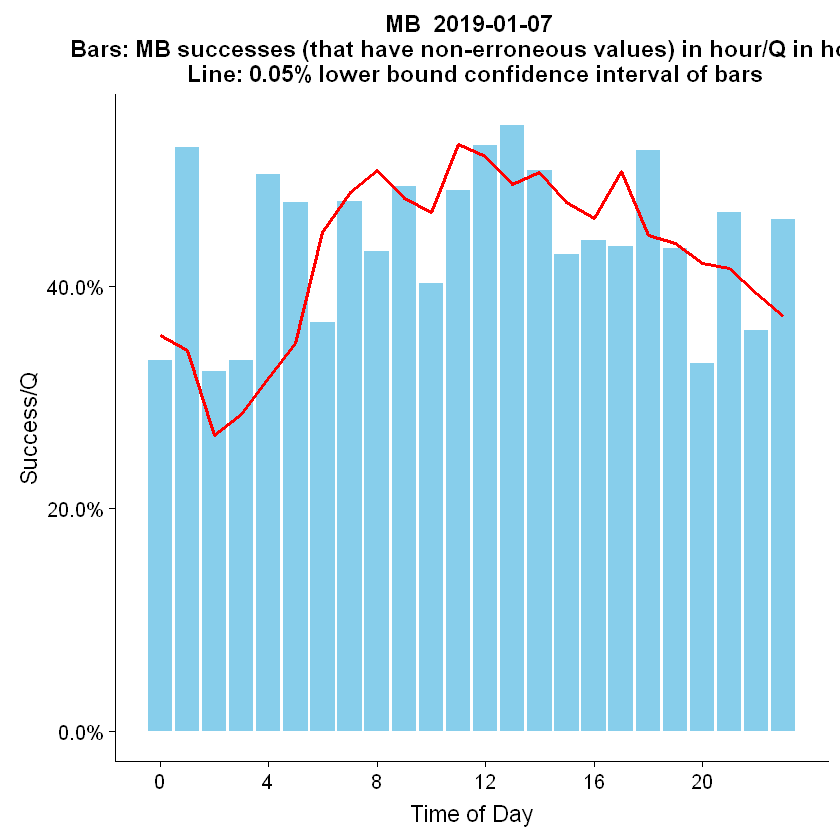

In [58]:
ggplot(
    data = ci_information, 
    mapping = aes(
        x = hour.session
    )
) +
geom_col(
    aes(y = r.session),
    fill = 'sky blue'
) + 
labs(
    x ="Time of Day", 
    y = "Success/Q", 
    title = paste(
        "MB ", getSessionInfo()$date,
        "\n", "Bars: MB successes (that have non-erroneous values) in hour/Q in hour", 
        "\n", "Line: 0.05% lower bound confidence interval of bars")
) + 
geom_line(
    aes(
        y = ci_lower
#         y = ifelse(
#             ci_lower < 0,
#             0.03 + runif(length(which(ci_lower < 0)),0,0.1),
#             ci_lower
#         )
    ), 
    color = 'red', 
    size=1
) + 
scale_y_continuous(
    labels = scales::percent 
) + 
scale_x_continuous(
    breaks = seq(0,23,4)
)# + geom_line(aes(x=hourofday, y=upper), color='springgreen4', size=1) + scale_y_continuous(labels=scales::percent) + scale_x_continuous(breaks=seq(0,23,4))
